In [2]:
# import required packages
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        'data/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch= 8369 // 64,
        epochs=100,
        validation_data=validation_generator,
        validation_steps= 1735 // 64)

# save model structure in jason file
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model.h5')


Found 8369 images belonging to 7 classes.
Found 1735 images belonging to 7 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
130/130 [==============================] - 51s 392ms/step - loss: 1.8029 - accuracy: 0.2213 - val_loss: 1.8781 - val_accuracy: 0.1979
Epoch 2/100
130/130 [==============================] - 53s 404ms/step - loss: 1.7760 - accuracy: 0.2396 - val_loss: 1.8508 - val_accuracy: 0.2043
Epoch 3/100
130/130 [==============================] - 53s 407ms/step - loss: 1.7250 - accuracy: 0.2936 - val_loss: 1.8139 - val_accuracy: 0.2963
Epoch 4/100
130/130 [==============================] - 53s 407ms/step - loss: 1.6502 - accuracy: 0.3565 - val_loss: 1.7309 - val_accuracy: 0.3565
Epoch 5/100
130/130 [==============================] - 53s 408ms/step - loss: 1.5859 - accuracy: 0.3884 - val_loss: 1.6938 - val_accuracy: 0.3686
Epoch 6/100
130/130 [==============================] - 53s 411ms/step - loss: 1.5465 - accuracy: 0.4149 - val_

In [ ]:
import cv2
import numpy as np
from keras.models import model_from_json


emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# load json and create model
json_file = open('model/emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("model/emotion_model.h5")
print("Loaded model from disk")

# start the webcam feed
cap = cv2.VideoCapture(0)

# pass here your video path
# you may download one from here : https://www.pexels.com/video/three-girls-laughing-5273028/
#cap = cv2.VideoCapture("sample video/sample zoom recording.mp4")

while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720))
    if not ret:
        break
    face_detector = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces available on camera
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    # take each face available on the camera and Preprocess it
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

        # predict the emotions
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Loaded model from disk


Loaded model from disk
Found 1735 images belonging to 7 classes.
-----------------------------------------------------------------
[[ 44   7   9  68  68  94  42]
 [  9   2   3  22  18  30   7]
 [ 13   3   1  22  25  44  22]
 [ 34   6   6  46  62  81  42]
 [ 39   5   7  63  65 112  51]
 [ 47  12   5  75  63 112  32]
 [ 28   8   5  48  42  58  28]]


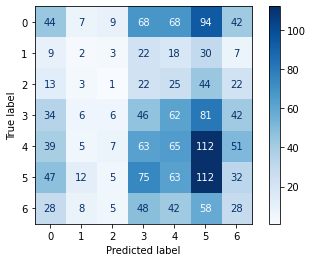

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.21      0.13      0.16       332
           1       0.05      0.02      0.03        91
           2       0.03      0.01      0.01       130
           3       0.13      0.17      0.15       277
           4       0.19      0.19      0.19       342
           5       0.21      0.32      0.26       346
           6       0.12      0.13      0.13       217

    accuracy                           0.17      1735
   macro avg       0.13      0.14      0.13      1735
weighted avg       0.16      0.17      0.16      1735



In [5]:
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay


emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# load json and create model
json_file = open('model/emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("model/emotion_model.h5")
print("Loaded model from disk")

# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# do prediction on test data
predictions = emotion_model.predict_generator(test_generator)

print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))